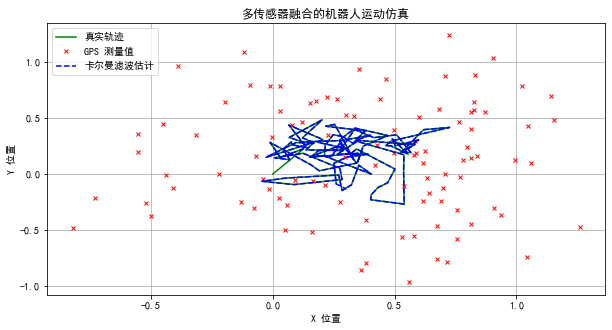

In [3]:
import numpy as np
from filterpy.kalman import KalmanFilter
import matplotlib.pyplot as plt

# 初始化卡尔曼滤波
dim_x = 5  # 状态向量维度 [x, y, v_x, v_y, theta]
dim_z = 8  # 观测向量维度 [delta_x, delta_y, v_x, v_y, gps_x, gps_y, lidar_x, lidar_y]
kf = KalmanFilter(dim_x=dim_x, dim_z=dim_z)

# 状态转移矩阵
dt = 0.1  # 时间步长
kf.F = np.array([[1, 0, dt, 0, 0],
                 [0, 1, 0, dt, 0],
                 [0, 0, 1, 0, 0],
                 [0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 1]])

# 观测矩阵
kf.H = np.array([[1, 0, 0, 0, 0],  # 里程计 delta_x
                 [0, 1, 0, 0, 0],  # 里程计 delta_y
                 [0, 0, 1, 0, 0],  # 里程计 v_x
                 [0, 0, 0, 1, 0],  # 里程计 v_y
                 [1, 0, 0, 0, 0],  # GPS x
                 [0, 1, 0, 0, 0],  # GPS y
                 [1, 0, 0, 0, 0],  # LiDAR x
                 [0, 1, 0, 0, 0]]) # LiDAR y

# 过程噪声协方差矩阵
kf.Q = np.eye(dim_x) * 0.1

# 观测噪声协方差矩阵
kf.R = np.eye(dim_z) * 0.5

# 初始状态和协方差
kf.x = np.array([0, 0, 1, 1, 0])  # [x, y, v_x, v_y, theta]
kf.P = np.eye(dim_x) * 1.0

# 模拟传感器数据
def simulate_sensors(true_state):
    # 真实状态
    x, y, v_x, v_y, theta = true_state
    
    # IMU 数据（加速度和角速度）
    acc_x = v_x * np.cos(theta) + np.random.normal(0, 0.1)
    acc_y = v_y * np.sin(theta) + np.random.normal(0, 0.1)
    gyro_z = np.random.normal(0, 0.05)  # 角速度噪声
    
    # 里程计数据（位移增量和速度）
    delta_x = v_x * dt + np.random.normal(0, 0.1)
    delta_y = v_y * dt + np.random.normal(0, 0.1)
    odom_v_x = v_x + np.random.normal(0, 0.1)
    odom_v_y = v_y + np.random.normal(0, 0.1)
    
    # GPS 数据
    gps_x = x + np.random.normal(0, 0.5)
    gps_y = y + np.random.normal(0, 0.5)
    
    # LiDAR 数据
    lidar_x = x + np.random.normal(0, 0.2)
    lidar_y = y + np.random.normal(0, 0.2)
    
    return np.array([delta_x, delta_y, odom_v_x, odom_v_y, gps_x, gps_y, lidar_x, lidar_y])

# 仿真过程
true_states = []
measurements = []
kf_states = []
for _ in range(100):
    # 真实状态更新
    true_state = kf.x.copy()
    true_states.append(true_state)
    kf.predict()
    
    # 生成传感器数据
    z = simulate_sensors(true_state)
    measurements.append(z)
    
    # 卡尔曼滤波更新
    kf.update(z)
    kf_states.append(kf.x.copy())

# 提取结果
true_x = [s[0] for s in true_states]
true_y = [s[1] for s in true_states]
meas_x = [z[4] for z in measurements]  # GPS x
meas_y = [z[5] for z in measurements]  # GPS y
kf_x = [s[0] for s in kf_states]
kf_y = [s[1] for s in kf_states]

# 可视化
plt.figure(figsize=(10, 5))
plt.plot(true_x, true_y, 'g-', label='真实轨迹')
plt.plot(meas_x, meas_y, 'rx', label='GPS 测量值', markersize=4)
plt.plot(kf_x, kf_y, 'b--', label='卡尔曼滤波估计')
plt.xlabel('X 位置')
plt.ylabel('Y 位置')
plt.title('多传感器融合的机器人运动仿真')
plt.legend()
plt.grid(True)
plt.show()



在多传感器融合的机器人运动仿真中，除了 IMU 和里程计，我们还可以引入其他传感器，例如 GPS 和 激光雷达（LiDAR），以进一步提高状态估计的精度。下面是一个扩展的仿真示例，展示如何融合 IMU、里程计、GPS 和 LiDAR 的数据。

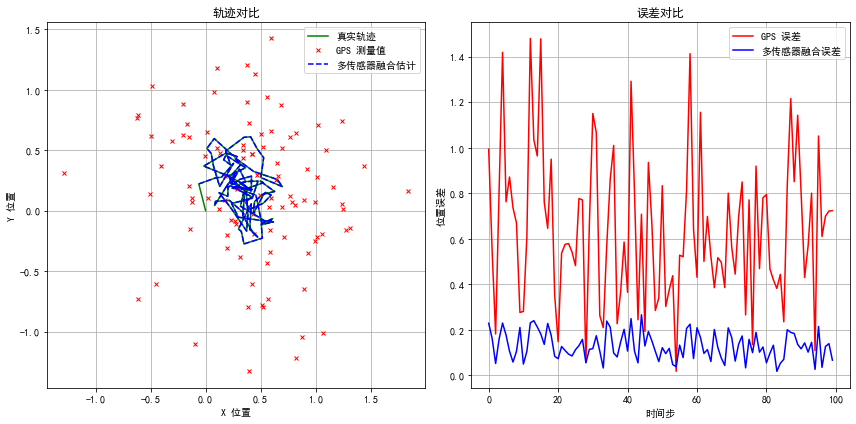

In [1]:
import numpy as np
from filterpy.kalman import KalmanFilter
import matplotlib.pyplot as plt

# 初始化卡尔曼滤波（多传感器融合）
dim_x = 5  # 状态向量维度 [x, y, v_x, v_y, theta]
dim_z = 8  # 观测向量维度 [delta_x, delta_y, v_x, v_y, gps_x, gps_y, lidar_x, lidar_y]
kf = KalmanFilter(dim_x=dim_x, dim_z=dim_z)

# 状态转移矩阵
dt = 0.1  # 时间步长
kf.F = np.array([[1, 0, dt, 0, 0],
                 [0, 1, 0, dt, 0],
                 [0, 0, 1, 0, 0],
                 [0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 1]])

# 观测矩阵
kf.H = np.array([[1, 0, 0, 0, 0],  # 里程计 delta_x
                 [0, 1, 0, 0, 0],  # 里程计 delta_y
                 [0, 0, 1, 0, 0],  # 里程计 v_x
                 [0, 0, 0, 1, 0],  # 里程计 v_y
                 [1, 0, 0, 0, 0],  # GPS x
                 [0, 1, 0, 0, 0],  # GPS y
                 [1, 0, 0, 0, 0],  # LiDAR x
                 [0, 1, 0, 0, 0]]) # LiDAR y

# 过程噪声协方差矩阵
kf.Q = np.eye(dim_x) * 0.1

# 观测噪声协方差矩阵
kf.R = np.eye(dim_z) * 0.5

# 初始状态和协方差
kf.x = np.array([0, 0, 1, 1, 0])  # [x, y, v_x, v_y, theta]
kf.P = np.eye(dim_x) * 1.0

# 模拟传感器数据
def simulate_sensors(true_state):
    # 真实状态
    x, y, v_x, v_y, theta = true_state
    
    # IMU 数据（加速度和角速度）
    acc_x = v_x * np.cos(theta) + np.random.normal(0, 0.1)
    acc_y = v_y * np.sin(theta) + np.random.normal(0, 0.1)
    gyro_z = np.random.normal(0, 0.05)  # 角速度噪声
    
    # 里程计数据（位移增量和速度）
    delta_x = v_x * dt + np.random.normal(0, 0.1)
    delta_y = v_y * dt + np.random.normal(0, 0.1)
    odom_v_x = v_x + np.random.normal(0, 0.1)
    odom_v_y = v_y + np.random.normal(0, 0.1)
    
    # GPS 数据
    gps_x = x + np.random.normal(0, 0.5)
    gps_y = y + np.random.normal(0, 0.5)
    
    # LiDAR 数据
    lidar_x = x + np.random.normal(0, 0.2)
    lidar_y = y + np.random.normal(0, 0.2)
    
    return np.array([delta_x, delta_y, odom_v_x, odom_v_y, gps_x, gps_y, lidar_x, lidar_y])

# 仿真过程
true_states = []
measurements = []
kf_states = []
for _ in range(100):
    # 真实状态更新
    true_state = kf.x.copy()
    true_states.append(true_state)
    kf.predict()
    
    # 生成传感器数据
    z = simulate_sensors(true_state)
    measurements.append(z)
    
    # 卡尔曼滤波更新
    kf.update(z)
    kf_states.append(kf.x.copy())

# 提取结果
true_x = [s[0] for s in true_states]
true_y = [s[1] for s in true_states]
gps_x = [z[4] for z in measurements]  # GPS x
gps_y = [z[5] for z in measurements]  # GPS y
kf_x = [s[0] for s in kf_states]
kf_y = [s[1] for s in kf_states]

# 计算误差
gps_errors = [np.sqrt((tx - gx)**2 + (ty - gy)**2) for tx, ty, gx, gy in zip(true_x, true_y, gps_x, gps_y)]
kf_errors = [np.sqrt((tx - kx)**2 + (ty - ky)**2) for tx, ty, kx, ky in zip(true_x, true_y, kf_x, kf_y)]

# 可视化
plt.figure(figsize=(12, 6))
# 绘制轨迹
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
# 轨迹对比
plt.subplot(1, 2, 1)
plt.plot(true_x, true_y, 'g-', label='真实轨迹')
plt.plot(gps_x, gps_y, 'rx', label='GPS 测量值', markersize=4)
plt.plot(kf_x, kf_y, 'b--', label='多传感器融合估计')
plt.xlabel('X 位置')
plt.ylabel('Y 位置')
plt.title('轨迹对比')
plt.legend()
plt.grid(True)

# 误差对比
plt.subplot(1, 2, 2)
plt.plot(gps_errors, 'r-', label='GPS 误差')
plt.plot(kf_errors, 'b-', label='多传感器融合误差')
plt.xlabel('时间步')
plt.ylabel('位置误差')
plt.title('误差对比')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


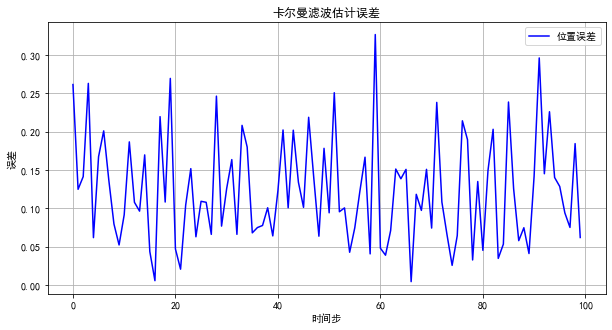

In [4]:
# 计算误差
errors = [np.sqrt((tx - kx)**2 + (ty - ky)**2) for tx, ty, kx, ky in zip(true_x, true_y, kf_x, kf_y)]

# 绘制误差
plt.figure(figsize=(10, 5))
plt.plot(errors, 'b-', label='位置误差')
plt.xlabel('时间步')
plt.ylabel('误差')
plt.title('卡尔曼滤波估计误差')
plt.legend()
plt.grid(True)
plt.show()
